# ResNet

I this notebook, I apply a ResNet to classify images in the CIFAR 100 dataset. 

In [1]:
import numpy as np
import pandas as pd
import torch
import torchvision
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F
import pickle
import time
import os
import matplotlib.pyplot as plt
import seaborn
seaborn.set_style('darkgrid')
seaborn.set_context('notebook')

%load_ext autoreload
%autoreload 2

## Load CIFAR 100 dataset

In [2]:
root = '/home/justin_pyron/pyron/python_code/datasets/'

cifar_100_train = torchvision.datasets.CIFAR100(root, train=True, download=True, 
                                                transform=torchvision.transforms.ToTensor())
cifar_100_val = torchvision.datasets.CIFAR100(root, train=False, download=True, 
                                               transform=torchvision.transforms.ToTensor())

with open(os.path.join(root, 'cifar-100-python/meta'), 'rb') as f:
    label_names = pickle.load(f)
label_mapping = dict(zip(range(len(label_names['fine_label_names'])), label_names['fine_label_names']))

print('Full train set size: {}'.format(len(cifar_100_train)))
print('Full validation set size: {}'.format(len(cifar_100_val)))

Files already downloaded and verified
Files already downloaded and verified
Full train set size: 50000
Full validation set size: 10000


# Class to help train model

In [3]:
class Trainer():
    '''Class providing functionality to a neural network'''
    
    def __init__(self, 
                 model, 
                 optimizer, 
                 loss_function, 
                 train_set, 
                 validation_set, 
                 batch_size):
        '''
        Arguments
        model : torch.nn.Module
            The model to train
        optimizer : torch.optim.Optimizer
            Optimizer for model's parameters
        loss_function : function
            The loss function to use
        train_set : torch.utils.data.dataset
            Training data set
        validation_set : torch.utils.data.dataset
            Validation data set
        batch_size : int
            How many images to include in each batch
        '''
        self.model = model
        self.optimizer = optimizer
        self.loss_F = loss_function
        self.loader_train = DataLoader(train_set,
                                       batch_size=batch_size,
                                       shuffle=True,
                                       num_workers=2)
        self.loader_validation = DataLoader(val_set,
                                            batch_size=batch_size,
                                            shuffle=True,
                                            num_workers=2)

        self.n_train = len(train_set)
        self.n_validation = len(validation_set)
        self.batch_size = batch_size
        
        self.n_epochs = 0
        self.loss = {'train': list(), 'validation': list()}
        self.accuracy = {'train': list(), 'validation': list()}
        
        
    def epoch(self, verbose=True):
        '''
        Performs one epoch of training and logs model performance
        
        Arguments
        ---------
        verbose : Bool
            If True, print performance metrics while training
        '''
        if verbose:
            print('Epoch: {:2}'.format(self.n_epochs))
        self.n_epochs += 1
        epoch_loss = {'train': 0, 'validation': 0}
        epoch_accuracy = {'train': 0, 'validation': 0}
        
        # Train stage
        self.model.train()
        for i, (x, y) in enumerate(self.loader_train):
            scores = self.model(x)
            loss = self.get_loss(scores, y, update=True)
            with torch.no_grad():
                accuracy = self.get_accuracy(scores, y)
                epoch_loss['train'] += loss*len(y)
                epoch_accuracy['train'] += accuracy*len(y)
                if verbose:
                    print('Train batch {:2}/{:2} | loss = {:6.4f} | accuracy = {:6.4f}'.format(
                          i, self.n_train//self.batch_size, loss, accuracy))
        self.loss['train'].append(epoch_loss['train']/self.n_train) # average loss
        self.accuracy['train'].append(epoch_accuracy['train']/self.n_train) # average accuracy

        # Eval stage
        self.model.eval()
        for i, (x, y) in enumerate(self.loader_validation):
            with torch.no_grad():
                scores = self.model(x)
                loss = self.get_loss(scores, y, update=False)
                accuracy = self.get_accuracy(scores, y)
                epoch_loss['validation'] += loss*len(y)
                epoch_accuracy['validation'] += accuracy*len(y)
                if verbose:
                    print('Eval batch {:2}/{:2} | loss = {:6.4f} | accuracy = {:6.4f}'.format(
                          i, self.n_validation//self.batch_size, loss, accuracy))
        self.loss['validation'].append(epoch_loss['validation']/self.n_validation)  # average loss
        self.accuracy['validation'].append(epoch_accuracy['validation']/self.n_validation) # average accuracy
        
    
    def get_loss(self, scores, y, update=False):
        '''
        Computes loss for one batch of data, and
        optionally makes gradient step
        
        Arguments
        ---------
        scores : torch.Tensor
            Tensor containing model output (pre-Softmax)
        y : torch.Tensor
            Tensor containing ground-truth labels
        update : Bool
            If True, make a gradient descent step
        '''
        loss = self.loss_F(scores, y)
        if update:
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()
        return loss.item()
    
    
    def get_accuracy(self, scores, y):
        '''
        Returns top-1 accuracy for one batch of data
        
        Arguments
        ---------
        scores : torch.Tensor
            Tensor containing model output (pre-Softmax)
        y : torch.Tensor
            Tensor containing ground-truth labels
        '''
        return (torch.argmax(scores, dim=1) == y).float().mean().item()



# Load data for model

In [4]:
subset_fraction = 1  # if you want to train using only a subset of data (e.g. while still prototyping)

n_train = len(cifar_100_train)
n_val = len(cifar_100_val)
idx_train = np.arange(n_train)
idx_val = np.arange(n_val)
np.random.shuffle(idx_train)
np.random.shuffle(idx_val)
idx_train = idx_train[:int(n_train * subset_fraction)]
idx_val = idx_val[:int(n_val * subset_fraction)]

train_set = torch.utils.data.Subset(cifar_100_train, idx_train)
val_set = torch.utils.data.Subset(cifar_100_val, idx_val)
print('Train set size: {}'.format(len(train_set)))
print('Validation set size: {}'.format(len(val_set)))

Train set size: 50000
Validation set size: 10000


# Initialize model

In [5]:
from ResNet import ResNet

learning_rate = 5e-3
L2_reg = 1e-4
batch_size = 1000

model = ResNet(depth_1=20,
               depth_2=30,
               depth_3=50,
               dropout_p=0.25)

opt = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=L2_reg)
loss_f = F.cross_entropy
t = Trainer(model, opt, loss_f, train_set, val_set, batch_size)

# Train model

In [18]:
n_epochs = 5
start = time.time()

for i in range(n_epochs):
    t.epoch(verbose=True)
    print('Took: {:.1f} seconds'.format(time.time() - start))


Epoch: 30
Train batch  0/50 | loss = 1.8363 | accuracy = 0.4700
Train batch  1/50 | loss = 1.8311 | accuracy = 0.4820
Train batch  2/50 | loss = 1.8204 | accuracy = 0.4910
Train batch  3/50 | loss = 1.8800 | accuracy = 0.4580
Train batch  4/50 | loss = 1.9323 | accuracy = 0.4600
Train batch  5/50 | loss = 1.8772 | accuracy = 0.4750
Train batch  6/50 | loss = 1.8876 | accuracy = 0.4520
Train batch  7/50 | loss = 1.7936 | accuracy = 0.4970
Train batch  8/50 | loss = 1.8956 | accuracy = 0.4770
Train batch  9/50 | loss = 1.7875 | accuracy = 0.4810
Train batch 10/50 | loss = 1.8732 | accuracy = 0.4460
Train batch 11/50 | loss = 1.8984 | accuracy = 0.4660
Train batch 12/50 | loss = 1.7697 | accuracy = 0.5040
Train batch 13/50 | loss = 1.8829 | accuracy = 0.4780
Train batch 14/50 | loss = 1.9330 | accuracy = 0.4460
Train batch 15/50 | loss = 1.8483 | accuracy = 0.4660
Train batch 16/50 | loss = 1.8276 | accuracy = 0.4810
Train batch 17/50 | loss = 1.8709 | accuracy = 0.4800
Train batch 18/50 

Train batch 31/50 | loss = 1.7637 | accuracy = 0.4960
Train batch 32/50 | loss = 1.8279 | accuracy = 0.4890
Train batch 33/50 | loss = 1.8287 | accuracy = 0.4790
Train batch 34/50 | loss = 1.8973 | accuracy = 0.4510
Train batch 35/50 | loss = 1.8930 | accuracy = 0.4690
Train batch 36/50 | loss = 1.8448 | accuracy = 0.4790
Train batch 37/50 | loss = 1.8399 | accuracy = 0.4710
Train batch 38/50 | loss = 1.8506 | accuracy = 0.4870
Train batch 39/50 | loss = 1.8556 | accuracy = 0.4670
Train batch 40/50 | loss = 1.8876 | accuracy = 0.4730
Train batch 41/50 | loss = 1.8032 | accuracy = 0.4800
Train batch 42/50 | loss = 1.8171 | accuracy = 0.4930
Train batch 43/50 | loss = 1.8920 | accuracy = 0.4790
Train batch 44/50 | loss = 1.9730 | accuracy = 0.4430
Train batch 45/50 | loss = 1.8163 | accuracy = 0.4910
Train batch 46/50 | loss = 1.7976 | accuracy = 0.4710
Train batch 47/50 | loss = 1.9281 | accuracy = 0.4540
Train batch 48/50 | loss = 1.9679 | accuracy = 0.4340
Train batch 49/50 | loss = 1

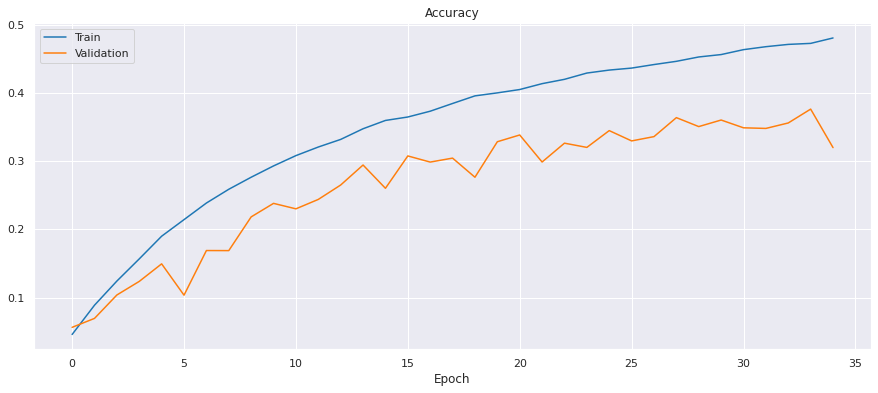

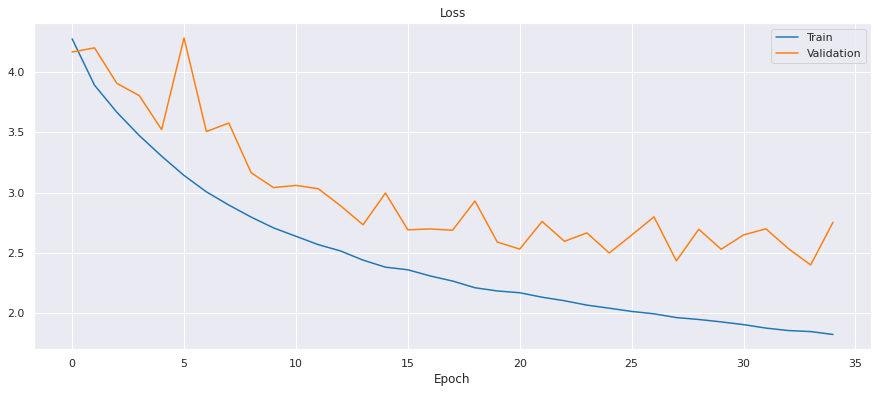

In [19]:
# Accuracy
plt.figure(figsize=(15,6))
plt.plot(t.accuracy['train'], label='Train')
plt.plot(t.accuracy['validation'], label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Loss
plt.figure(figsize=(15,6))
plt.plot(t.loss['train'], label='Train')
plt.plot(t.loss['validation'], label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()
